In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [3]:
#include("../../telegram/notifications.jl");

In [4]:
T = 20
N = 100
c = 2.5
gg = erdos_renyi(N, c/N)
#gg = Graphs.binary_tree(5)
#gg = Graphs.regular_tree(4,4)
N = nv(gg)
# k = 4
# gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.4
ρ = 0.15
σ = 0.15
γ = 1/N;

rng = MersenneTwister(111)
sis = SIRS(g, λ, ρ, σ, T; γ)
# sis = SIS(g, λ, ρ, T; γ)


LoadError: UndefVarError: bp not defined

In [65]:
bp = mpbp(sis)
obs_times = [10]
nobs = floor(Int, N * length(obs_times) * 0.75)
obs_fraction = N / nobs
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);
# X, observed = draw_node_observations!(bp, nobs, softinf=Inf; rng);
sum(X[:, obs_times .+ 1] .!= 1), sum(X[:, 1] .== 2)

(57, 1)

In [66]:
Iterators.flatten(bp.ϕ) |> collect |> unique

5-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0]
 [1.0, 1.0, 1.0]
 [1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]

In [67]:
using ProgressMeter
# A callback to print info and save stuff during the iterations 
struct CB_BP3{TP<:ProgressUnknown, F, XT}
    prog :: TP
    m    :: Vector{Vector{Vector{Float64}}} 
    Δs   :: Vector{Float64}
    f    :: F
    X    :: XT

    function CB_BP3(bp::MPBP, X::XT; showprogress::Bool=true, f::F=(x,i)->x, info="") where {F, XT}
        dt = showprogress ? 0.1 : Inf
        isempty(info) || (info *= "\n")
        prog = ProgressUnknown(desc=info*"Running MPBP: iter", dt=dt)
        TP = typeof(prog)

        m = [[expectation.(x->f(x,i), marginals(bp.b[i])) for i in eachindex(bp.b)]]
        Δs = zeros(0)
        new{TP,F, XT}(prog, m, Δs, f, X)
    end
end

function (cb::CB_BP3)(bp::MPBP, it::Integer, svd_trunc::SVDTrunc)
    marg_new = [expectation.(x->cb.f(x,i), marginals(bp.b[i])) for i in eachindex(bp.b)]
    marg_old = cb.m[end]
    Δ = isempty(marg_new) ? NaN : mean(mean(abs, mn .- mo) for (mn, mo) in zip(marg_new, marg_old))
    push!(cb.Δs, Δ)
    push!(cb.m, marg_new)
    b_bp = beliefs(bp)
    next!(cb.prog, showvalues=[(:Δ,Δ), summary_compact(svd_trunc), (:O, sum(b_bp[i][t][X[i,t]] for t = 1:T, i = 1:N))])
    flush(stdout)
    return Δ
end

In [93]:
reset!(bp)

false

In [105]:
cb = CB_BP3(bp, X)
#@telegram "sis inference single instance" begin
iters, = iterate!(bp, maxiter=10; svd_trunc = TruncBond(3), cb, tol=1e-4, damp=0.0);

#end;

Running MPBP: iter 5 	 Time: 0:00:05
  Δ:                9.217037357406557e-5
  SVD Matrix size:  3
  O:                1426.3980967398331

In [97]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

LoadError: ArgumentError: step cannot be zero

In [98]:
b_bp = beliefs(bp)
p_bp = [[bᵗ[INFECTED] for bᵗ in bb] for bb in b_bp];

In [99]:
true_infections = [UnitRange{Int64}[] for _ in 1:N]
for i in 1:N
    start = -1
    for t in 1:T+1
        if X[i,t] == INFECTED
            start == -1 && (start = t)
        else
            start != -1 && ( push!(true_infections[i], start-1:t-2); start = -1 )
        end
    end
    start != -1 && push!(true_infections[i], start-1:T)
    push!(true_infections[i], T+1:T+2)
end

In [100]:
using ColorSchemes
cg = cgrad(:deep)[1:150]
cg = cgrad(:GnBu_3, rev=true)
cg = cgrad(:haline)[150:end]
cg = cgrad(:tokyo, rev=false)[50:end]
cg = cgrad(:viridis, alpha=1.0)[80:end]
cg = cgrad([theme_palette(:auto)[1], :yellow], 0.6)

In [101]:
Tplot = T
X_bp = reduce(hcat, p_bp)

perm = sortperm(true_infections)
# perm = collect(eachindex(true_infections))
true_infections_sorted = true_infections[perm]
X_bp_sorted = X_bp[:,perm]

pl = heatmap(1:N, 0:T, X_bp_sorted, yrange=(0,Tplot), c=cg, xlabel="i", ylabel="t", colorbar_title="\$P(x_i^t=I)\$")

pl2 = deepcopy(pl)
pl3 = plot(xlabel="i", ylabel="t", xlims=(1,N), yrange=(0,Tplot));

In [102]:
cols = [:white, :red, :black]
iperm = invperm(perm)
for (i,t) in observed
    scatter!(pl, iperm[i:i], [t-1], m=:o, ms=3, msc=:auto, c=cols[X[i,t]], label="")
end

In [103]:
label = "true infections"
for i in 1:N
    for a in true_infections_sorted[i]
        plot!(pl, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
        label = ""
        plot!(pl3, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
    end
end

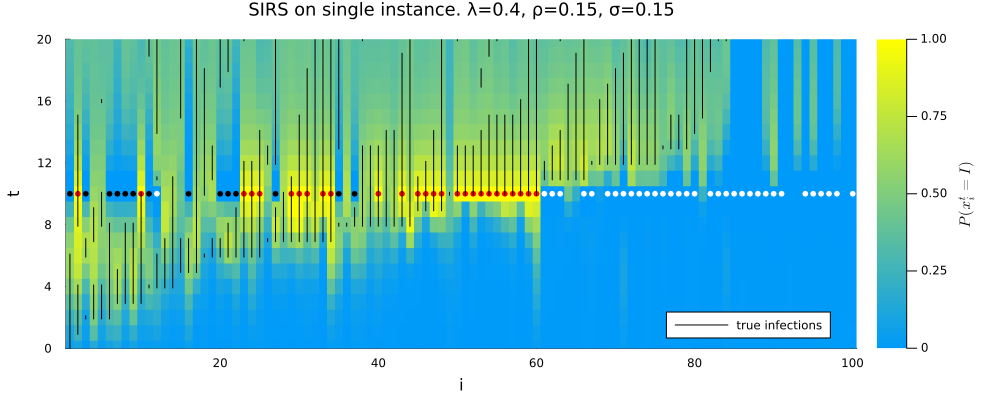

In [104]:
# hline!(pl, obs_times, c=:orange, ls=:dash, label="observations", legend=:outertopright,
#     size=(1000,400))
# println("Observations at times: ", obs_times)
plot(pl, margin=5Plots.mm, 
    title="SIRS on single instance. λ=$(round(λ, digits=3)), ρ=$(round(ρ, digits=3)), σ=$(round(σ, digits=3))",
    #Fraction of observed nodes: $(round(obs_fraction, digits=3))", 
    titlefontsize=12, size=(1000,400), yrange=(0,Tplot), legend=:bottomright, yticks=0:(T÷5):T, widen=false)

In [90]:
sortperm(X_bp[1,:])

100-element Vector{Int64}:
  24
  96
  41
  62
  14
   3
  28
  89
  70
   9
  97
  57
  81
   ⋮
  99
  52
  60
  21
  83
  47
  54
 100
  84
  22
  25
  26

In [92]:
(1:N)[X[:,1] .== 2]

1-element Vector{Int64}:
 54

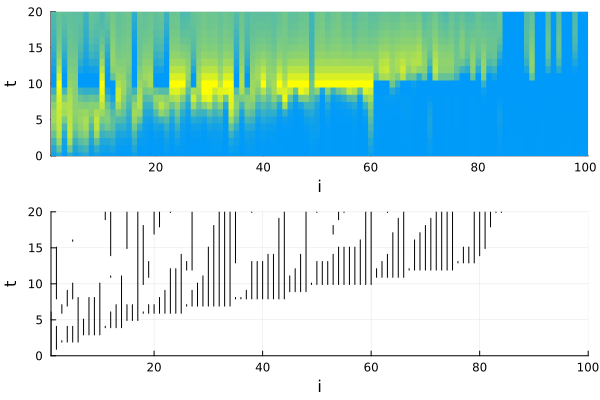

In [87]:
pl4 = heatmap(1:N, 0:T, X_bp_sorted, yrange=(0,Tplot), c=cg, xlabel="i", ylabel="t", colorbar=false)

plot(pl4, pl3, layout=(2,1))

In [38]:
# jldsave("plot_data/sis_inference_single_instance.jld2"; 
#     N, T, X_bp, true_infections, obs_times, k, λ, ρ, obs_fraction);